In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ranksums
from decimal import Decimal
import math
import warnings
import statsmodels.api as sm
import os
import glob



# Format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 700)
sns.set(font_scale=1.1)  

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=RuntimeWarning)


from matplotlib.cbook import boxplot_stats  # Para obtener los outliers en un boxplot
# boxplot_stats(df_blocks_filtered['antisaccade_errors']).pop(0)['fliers']


In [8]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    baseline_start=-200.0,
    baseline_end=100.0,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER=1.5,
    filter_by_block=False,
    selected_block=1,
    savgol_flag=False
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query("not webgazer_data.isnull() and isTutorial == False")

    # Le agrego numero de bloque al df
    blocks = sum([[i] * 20 for i in range(1, 17)], [])
    df_saccade.loc[:, "block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query("typeOfSaccade == @type_of_saccade")

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query("block == @selected_block")

    webgazer_data = df_saccade["webgazer_data"].map(eval)

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    ts_xs = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # Interpolate
        if interpolate:
            f1 = interp1d(ts, xs, kind="linear")
            samples = int((ts[-1] - (-200)) / 30) #  900 ms / 30 Hz te daria 30 samples
            ts_new = np.linspace(-200, ts[-1], samples)
            xs = f1(ts_new)
            ts = ts_new

        # LOW_FILTER_PIX = 168 # Un 10% para cada lado
        # HIGH_FILTER_PIX = 1512 # Un 10% para cada lado
        # # filtro pasa banda de trials
        # if any(xs > HIGH_FILTER_PIX) or any(xs < LOW_FILTER_PIX):
        #     continue

        # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
        x_base = np.median(
            xs[(ts > baseline_start) & (ts < baseline_end)]
        )  # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede antibar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts <= 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y
        #  para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # # 6. Savitzky-Golay filter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        if savgol_flag:
            xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira
        xs_after_baseline = xs[ts > baseline_end]
        ts_after_baseline = ts[ts > baseline_end]
        if type_of_saccade == "prosaccade":
            is_sacc_error_in_trial = np.any(
                xs_after_baseline < -threshold_to_accept_sacc
            )
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1
                err_prosacc_idx = np.where(
                    xs_after_baseline < -threshold_to_accept_sacc
                )[0][0]
                err_prosacc_time = ts_after_baseline[err_prosacc_idx]
                pro_sacc_errors_rt.append(f"{err_prosacc_time:.2f}")
            else:
                corr_prosacc_idx = np.where(
                    xs_after_baseline >= threshold_to_accept_sacc
                )[0][0]
                corr_prosacc_time = ts_after_baseline[corr_prosacc_idx]
                pro_sacc_correct_rt.append(f"{corr_prosacc_time:.2f}")

        elif type_of_saccade == "antisaccade":
            is_anti_sacc_error_in_trial = np.any(
                xs_after_baseline > threshold_to_accept_sacc
            )
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1
                err_antisacc_idx = np.where(
                    xs_after_baseline > threshold_to_accept_sacc
                )[0][0]
                err_antisacc_time = ts_after_baseline[err_antisacc_idx]
                anti_sacc_errors_rt.append(f"{err_antisacc_time:.2f}")

            else:
                corr_antisacc_idx = np.where(
                    xs_after_baseline <= -threshold_to_accept_sacc
                )[0][0]
                corr_antisacc_time = ts_after_baseline[corr_antisacc_idx]
                anti_sacc_correct_rt.append(f"{corr_antisacc_time:.2f}")

        ts_xs.append((ts, xs))

    try:
        trials_rejected = 100 - (
            len(ts_xs) / len(webgazer_data) * 100
        )  # len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan

    return {
        "ts_xs": ts_xs,
        "number_of_trials_remained": len(ts_xs),
        "pro_sacc_errors": pro_sacc_errors,
        "pro_sacc_errors_perc": pro_saccades_errors_perc,
        "anti_sacc_errors": anti_sacc_errors,
        "anti_sacc_errors_perc": anti_saccades_errors_perc,
        "trials_rejected": trials_rejected,
        "pro_sacc_errors_rt": pro_sacc_errors_rt,
        "pro_sacc_correct_rt": pro_sacc_correct_rt,
        "anti_sacc_errors_rt": anti_sacc_errors_rt,
        "anti_sacc_correct_rt": anti_sacc_correct_rt,
        "age": int(eval(df["response"][1])["age"]),
        "px2degree": df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_width_pixels": df[~df["win_width_deg"].isna()]["win_width_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_height_pixels": df[~df["win_height_deg"].isna()]["win_height_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
    }


def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = (
            (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))
        ) + a
        values_normalized.append(res)
    return np.array(values_normalized)


def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(
        3, 1, height_ratios=[1, 4, 1], sharex=True, constrained_layout=True
    )

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinate predictions")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2)

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df["pro_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["pro_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2], height=0.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0], height=0.1)
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[0].set_xlim([-200, 700])

    else:
        data_error = [float(i) for i in df["anti_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["anti_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0], height=0.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2], height=0.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    plt.suptitle(f"{type_of_saccade}")
    fig.align_ylabels(axs[:])
    fig.supxlabel("time (ms)")
    plt.show()


### Load all files and separate in blocks


In [9]:
# SEPARACION EN BLOQUES

ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
REJECTED_SUJ = []
all_dfs = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    df = pd.read_csv(suj)
    if suj in REJECTED_SUJ:
        continue
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]

    _df_processed_signal = pd.DataFrame(
        {
            "subject": None,
            "prosaccade": None,
            "antisaccade": None,
            "prosaccade_errors": None,
            "antisaccade_errors": None,
        },
        index=[],
    )

    subjects = []
    prosaccade_trials_remained = []
    antisaccade_trials_remained = []
    pro_saccades = []
    anti_saccades = []
    pro_saccades_errors = []
    pro_saccades_errors_perc = []

    anti_saccades_errors = []
    anti_saccades_errors_perc = []
    trials_rejected_prosaccade = []
    trials_rejected_antisaccade = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []
    age = []
    px2degree = []
    block_number = []

    print(suj)


    for block in range(1, 17):
        anti_saccade_dict = pre_processing(
            df,
            type_of_saccade="antisaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block,
        )
        pro_saccade_dict = pre_processing(
            df,
            type_of_saccade="prosaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block
        )
        subjects.append(suj)
        pro_saccades.append(pro_saccade_dict["ts_xs"])
        anti_saccades.append(anti_saccade_dict["ts_xs"])

        prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
        antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    
        pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
        pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])
        anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
        anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
        trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])
        trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
        pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
        pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
        anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
        anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
        age.append(anti_saccade_dict["age"])
        px2degree.append(pro_saccade_dict["px2degree"])
        block_number.append(block)
        # print(" --- ")

    _df_processed_signal["subject"] = subjects
    _df_processed_signal["prosaccade"] = pro_saccades
    _df_processed_signal["antisaccade"] = anti_saccades
    _df_processed_signal["prosaccade_errors"] = pro_saccades_errors
    _df_processed_signal["antisaccade_errors"] = anti_saccades_errors
    _df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
        pro_saccades_errors
    )
    _df_processed_signal[
        "trials_rejected_antisaccade_percentage"
    ] = trials_rejected_antisaccade
    _df_processed_signal[
        "trials_rejected_prosaccade_percentage"
    ] = trials_rejected_prosaccade
    _df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
    _df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
    _df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
    _df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

    # median
    _df_processed_signal["pro_sacc_errors_rt_median"] = _df_processed_signal[
        "pro_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["pro_sacc_correct_rt_median"] = _df_processed_signal[
        "pro_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_errors_rt_median"] = _df_processed_signal[
        "anti_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_correct_rt_median"] = _df_processed_signal[
        "anti_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))

    # Percentage of errors
    _df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
    _df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc

    _df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
    _df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained


    _df_processed_signal["age"] = age
    _df_processed_signal["px2degree"] = px2degree
    _df_processed_signal['block'] = block_number


    all_dfs.append(_df_processed_signal)

print(" ")

df_all_blocks = pd.concat(all_dfs)

print("df_all_blocks ready✅")

processing ...
111
119
112
118
107
125
113
114
109
110
98
126
91
123
127
117
103
124
102
92
99
105
115
101
100
104
 
df_all_blocks ready✅


### Filtering blocks

In [39]:
# Constants
MAX_NUMBER_INCORRECTS_BY_BLOCK = (
    10  # Esto implica que en un bloque hizo al menos el 50% mal
)
FIRST_BLOCK = 1
LAST_BLOCK = 16

# Filter
df_blocks_filtered = (
    df_all_blocks.query(
        "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
    )  # Con la mitad de los bloques
    .groupby("subject")
    .agg(
        {
            "prosaccade": list,
            "antisaccade": list,
            "prosaccade_errors": "sum",
            "antisaccade_errors": "sum",
            "prosaccade_trials_remained": "sum",
            "antisaccade_trials_remained": "sum",
            "pro_sacc_errors_rt": "sum",
            "pro_sacc_correct_rt": "sum",
            "anti_sacc_errors_rt": "sum",
            "anti_sacc_correct_rt": "sum",
            "pro_sacc_errors_rt_median": np.nanmean,
            "anti_sacc_errors_rt_median": np.nanmean,
            "pro_sacc_correct_rt_median": np.nanmean,
            "anti_sacc_correct_rt_median": np.nanmean,
            "block": lambda x: x.nunique(),
            "age": pd.Series.mode,  # TODO: MAKE THE SAME WITH OTHER SIMILAR DATA
            "px2degree": pd.Series.mode,
        }
    )
)

df_blocks_filtered = df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)
df_blocks_filtered["max_number_incorrect_by_block"] = MAX_NUMBER_INCORRECTS_BY_BLOCK
df_blocks_filtered.insert(
    2,
    "delta_errors",
    df_blocks_filtered["antisaccade_errors"] - df_blocks_filtered["prosaccade_errors"],
)


# Percentage
df_blocks_filtered["prosaccade_errors_perc"] = (
    df_blocks_filtered["prosaccade_errors"]
    / df_blocks_filtered["prosaccade_trials_remained"]
) * 100


df_blocks_filtered["antisaccade_errors_perc"] = (
    df_blocks_filtered["antisaccade_errors"]
    / df_blocks_filtered["antisaccade_trials_remained"]
) * 100

# Data wrangling
prosaccs_all = []
antisaccs_all = []
for suj in range(len(df_blocks_filtered)):
    prosaccs_one_suj = []
    antisaccs_one_suj = []
    prosaccades = df_blocks_filtered.iloc[suj]["prosaccade"]
    antisaccades = df_blocks_filtered.iloc[suj]["antisaccade"]
    for block_pro in prosaccades:
        if block_pro:
            for trial in block_pro:
                prosaccs_one_suj.append(trial)

    for block_anti in prosaccades:
        if block_anti:
            for trial in block_anti:
                antisaccs_one_suj.append(trial)

    prosaccs_all.append(prosaccs_one_suj)
    antisaccs_all.append(antisaccs_one_suj)

df_blocks_filtered["prosaccade"] = prosaccs_all
df_blocks_filtered["antisaccade"] = antisaccs_all

print("df_blocks_filtered ready ✅")


df_blocks_filtered ready ✅


0.0607
N=26, blocks=7
Cantidad de bloques filtrados: 237


/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, '\nPercentage of incorrect trials\nN suj = 26\nblocks = 7\np_value = 0.0607\n')

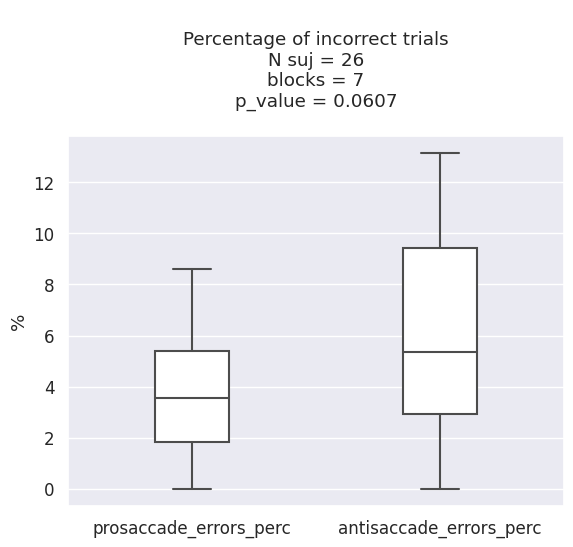

In [40]:
# Plot errors

ax = sns.boxplot(
    data=df_blocks_filtered[["prosaccade_errors_perc", "antisaccade_errors_perc"]],
    width=0.3,
)
ax.set_ylabel("%")

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")


p_value = round((
    ranksums(
        df_blocks_filtered["prosaccade_errors_perc"],
        df_blocks_filtered["antisaccade_errors_perc"],
    )[1]
), 4)

print(p_value)
print(f"N={len(df_blocks_filtered)}, blocks={df_blocks_filtered['remained_blocks'].max()}")

print(f"Cantidad de bloques filtrados: {(len(df_blocks_filtered['remained_blocks']) * 16)  - df_blocks_filtered['remained_blocks'].sum()}")

df_blocks_filtered.describe()

plt.title(f"""
Percentage of incorrect trials
N suj = {len(df_blocks_filtered)}
blocks = {df_blocks_filtered['remained_blocks'].max()}
p_value = {p_value}
""")

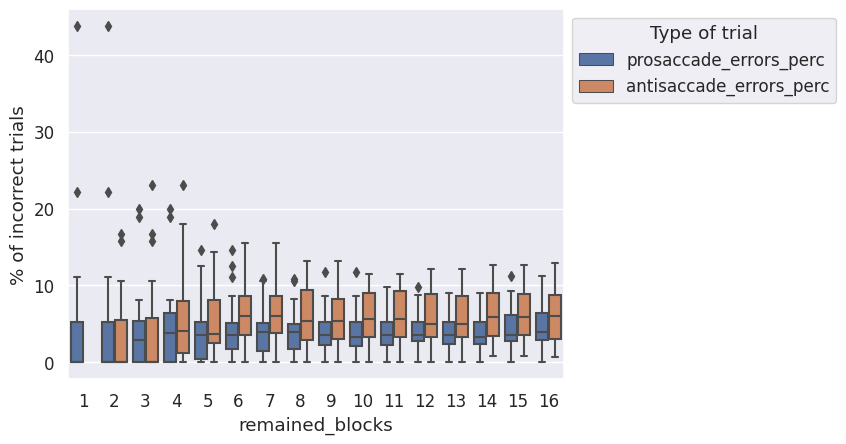

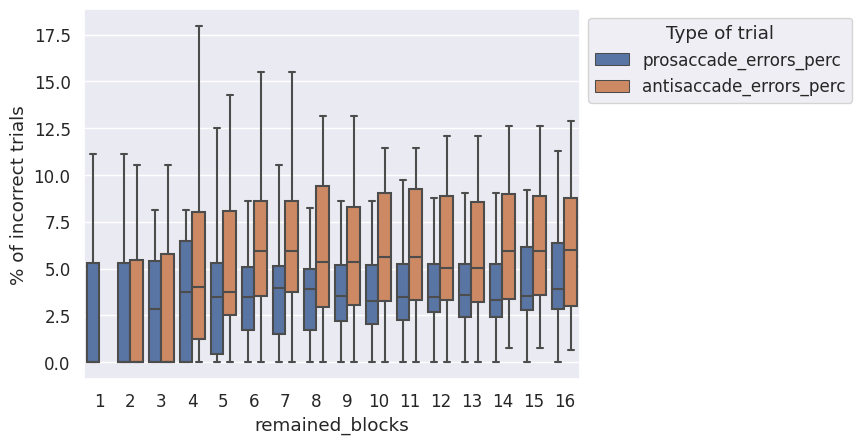

In [41]:
# Incorrectos por bloque
all_dfs = []
for last_block in range(1, 17):
    # filtrar bloques

    FIRST_BLOCK = 1
    LAST_BLOCK = last_block

    _df_blocks_filtered = (
        df_all_blocks.query(
            "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
        )  # Con la mitad de los bloques
        .groupby("subject")
        .agg(
            {
                "prosaccade_errors": "sum",
                "antisaccade_errors": "sum",
                "prosaccade_trials_remained": "sum",
                "antisaccade_trials_remained": "sum",
                "pro_sacc_errors_rt": "sum",
                "pro_sacc_correct_rt": "sum",
                "anti_sacc_errors_rt": "sum",
                "anti_sacc_correct_rt": "sum",
                "pro_sacc_errors_rt_median": np.nanmean,
                "anti_sacc_errors_rt_median": np.nanmean,
                "pro_sacc_correct_rt_median": np.nanmean,
                "anti_sacc_correct_rt_median": np.nanmean,
                "block": lambda x: x.nunique(),
            }
        )
    )

    _df_blocks_filtered = _df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)


    # Percentage
    _df_blocks_filtered["prosaccade_errors_perc"] = (
        _df_blocks_filtered["prosaccade_errors"]
        / _df_blocks_filtered["prosaccade_trials_remained"]
    ) * 100


    _df_blocks_filtered["antisaccade_errors_perc"] = (
        _df_blocks_filtered["antisaccade_errors"]
        / _df_blocks_filtered["antisaccade_trials_remained"]
    ) * 100
    all_dfs.append(_df_blocks_filtered)

all_dataframes = pd.concat(all_dfs)

all_dataframes

# Plot
ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()

/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


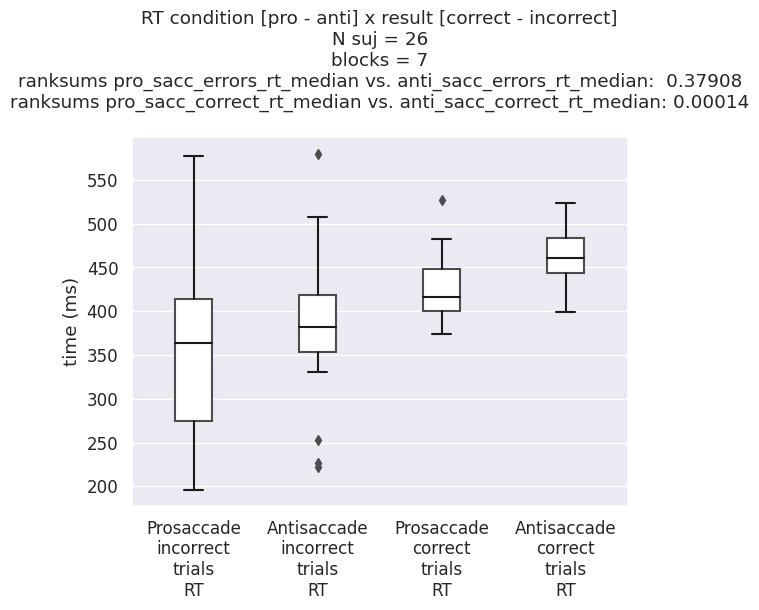

In [42]:
# RT VERSION CON BLOQUES

# Boxplot with means
ax = sns.boxplot(
    data=df_blocks_filtered[
        [
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]
    ],
    width=0.3,
)

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")

plt.ylabel("time (ms)")
ax.set_xticklabels(
    [
        "Prosaccade\nincorrect\ntrials\nRT",
        "Antisaccade\nincorrect\ntrials\nRT",
        "Prosaccade\ncorrect\ntrials\nRT",
        "Antisaccade\ncorrect\ntrials\nRT",
    ]
)

plt.setp(ax.artists, edgecolor="k", facecolor="w")
plt.setp(ax.lines, color="k")


title = (
    f"""RT condition [pro - anti] x result [correct - incorrect]
N suj = {len(df_blocks_filtered)}
blocks = {df_blocks_filtered['remained_blocks'].max()}
ranksums pro_sacc_errors_rt_median vs. anti_sacc_errors_rt_median:  {Decimal(ranksums(df_blocks_filtered['pro_sacc_errors_rt_median'],df_blocks_filtered['anti_sacc_errors_rt_median'], nan_policy='omit')[1]):.5f}
ranksums pro_sacc_correct_rt_median vs. anti_sacc_correct_rt_median: {Decimal(ranksums(df_blocks_filtered['pro_sacc_correct_rt_median'],df_blocks_filtered['anti_sacc_correct_rt_median'], nan_policy='omit')[1]):.5f}
"""
)

df_blocks_filtered.describe()

plt.title(title)
plt.show()

### PLOT EYE DATA

In [ ]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split("/")[-1].split(".")[0].split("_")[-1]
    print(suj)
    one_subject(df_blocks_filtered, suj, "prosaccade")
    one_subject(df_blocks_filtered, suj, "antisaccade")

### Saccade detection


### Preparing test dataset

`infile`: Data file with eye gaze recordings to process. <br>
The first two columns in this file must contain x and y coordinates, while each line is a timepoint (no header). <br>
The file is read with NumPy's recfromcsv and may be compressed. The columns are expected to be seperated by tabulators (\t).

### Analisis trial por trial

In [ ]:

# Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
OUT_FOLDER = "./pro_saccade_detection_by_trial/"
SFREQ = 30  # Sampling rate after inteporlation
TYPE_OF_SACCADE = "prosaccade"

for SUJ in range(len(df_blocks_filtered)):
    for trial_num, data in enumerate(df_blocks_filtered.iloc[SUJ][TYPE_OF_SACCADE]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial_num}")
        rows = []
        # Remodnav parameters
        FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial_{trial_num}.csv"
        PX2DEG = df_blocks_filtered["px2degree"][SUJ]
        OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial_{trial_num}.tsv"
        x_samples = data[1]
        t_samples = data[0]

        # create a new row as a dictionary
        new_row = {
            "x": x_samples,
            "y": np.zeros(len(x_samples)),
            "t": t_samples,
            "trial": trial_num,
        }
        rows.append(new_row)

        df_sacc = pd.DataFrame(rows)
        df_sacc = df_sacc.explode(["x", "y", "t"], ignore_index=True)
        df_sacc = df_sacc[["x", "y"]]

        # One trial data
        samples = len(x_samples)
        df_sacc.iloc[:samples + 2].to_csv(
            OUT_FOLDER + FNAME, sep="\t", header=False, index=False
        )

        print("\nRunning saccades and fixations detection")

        # Run Remodnav not considering pursuit class and min fixations 100 ms
        command = (
            f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
            f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
        )
        os.system(command)

    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")


In [37]:
import glob
path = './saccade_detection_by_trial/'
df = pd.concat([pd.read_csv(f, sep='\t' ) for f in glob.glob(path+'fix_sac_detection_suj_115_trial_*.tsv')])
df.shape


(426, 11)

### VERSION POR SUJETO SIN SEPARACION POR TRIALS

In [ ]:
#Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
OUT_FOLDER = './saccade_detection/'
SFREQ = 30 # Sampling rate after inteporlation

for SUJ in range(len(df_blocks_filtered)):
    FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial.csv"
    PX2DEG = df_blocks_filtered['px2degree'][SUJ]
    OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial.tsv"
    rows = []
    for trial, data in enumerate(df_blocks_filtered.iloc[SUJ]["prosaccade"]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial}")
        # Remodnav parameters
        x_samples = data[1]
        t_samples = data[0]
        
        # create a new row as a dictionary
        new_row = {"x": x_samples, "y": np.zeros(len(x_samples)), "t": t_samples}
        rows.append(new_row)

    df_sacc_detect_test = pd.DataFrame(rows)
    df_sacc_detect_test_expl = df_sacc_detect_test.explode(
        ["x", "y", "t"], ignore_index=True
    )

    df_sacc_detect_test_expl = df_sacc_detect_test_expl[['x', 'y']]

    # Datos de un sujeto
    samples = len(x_samples)
    df_sacc_detect_test_expl.to_csv(OUT_FOLDER + FNAME, sep="\t", header=False, index=False)

    print("\nRunning saccades and fixations detection")

    
    # Run Remodnav not considering pursuit class and min fixations 100 ms
    command = (
        f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
        f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
    )
    os.system(command)


    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")
    
    

In [59]:
sujetos = [int(i.split('/')[-1].split('.')[0].split('_')[-1]) for i in glob.glob('raw_data/*.csv')]

perc_sacc_detected = {}

for sujeto in sujetos:
    all_dfs_one_suj = []
    path = './pro_saccade_detection_by_trial/'

    for f in sorted(glob.glob(path+f'fix_sac_detection_suj_{sujeto}_trial_*.tsv'), key=os.path.getmtime):
        _df = pd.read_csv(f, sep='\t' )
        _df['trial'] = f.split("/")[-1].split('.')[0].split("_")[-1]
        all_dfs_one_suj.append(_df)


    dfs = pd.concat(all_dfs_one_suj).reset_index()
    res = (dfs.query("label == 'SACC' or label == 'ISAC'")['trial'].nunique() / dfs['trial'].nunique())  * 100
    dfs.query("label == 'SACC' or label == 'ISAC'").reset_index()
    perc_sacc_detected[sujeto] = res

perc_sacc_detected

{111: 15.517241379310345,
 119: 31.57894736842105,
 112: 59.32203389830508,
 118: 61.81818181818181,
 107: 60.3448275862069,
 125: 80.0,
 113: 70.6896551724138,
 114: 70.6896551724138,
 109: 36.84210526315789,
 110: 58.82352941176471,
 98: 32.0,
 126: 61.40350877192983,
 91: 65.45454545454545,
 123: 82.75862068965517,
 127: 80.0,
 117: 48.07692307692308,
 103: 53.44827586206896,
 124: 67.24137931034483,
 102: 84.61538461538461,
 92: 40.35087719298245,
 99: 65.45454545454545,
 105: 69.64285714285714,
 115: 67.24137931034483,
 101: 42.857142857142854,
 100: 36.206896551724135,
 104: 64.40677966101694}

In [ ]:

all_dfs_one_suj = []
sujeto = 99
path = './pro_saccade_detection_by_trial/'

for f in sorted(glob.glob(path+f'fix_sac_detection_suj_{sujeto}_trial_*.tsv'), key=os.path.getmtime):
    _df = pd.read_csv(f, sep='\t' )
    _df['trial'] = f.split("/")[-1].split('.')[0].split("_")[-1]
    all_dfs_one_suj.append(_df)


dfs = pd.concat(all_dfs_one_suj).reset_index()
print( (dfs.query("label == 'SACC' or label == 'ISAC'")['trial'].nunique() / dfs['trial'].nunique())  * 100, "%")

dfs.query("label == 'SACC' or label == 'ISAC'").reset_index()

In [45]:
sorted(glob.glob(path+'fix_sac_detection_suj_110_trial_*.tsv'), key=os.path.getmtime)

fix_sac_detection_suj_110_trial_0.tsv

[]

In [46]:
path = './pro_saccade_detection_by_trial/'
df = pd.concat([pd.read_csv(f, sep='\t' ) for f in sorted(glob.glob(path+'fix_sac_detection_suj_110_trial_*.tsv'), key=os.path.getmtime)])
df  = df.reset_index()
df.shape

(124, 12)

In [47]:
df

,index,onset,duration,label,start_x,start_y,end_x,end_y,amp,peak_vel,med_vel,avg_vel
0,0,0.000,1.100,FIXA,-0.1,0.0,0.9,0.0,35.534,266.350,18.238,50.063
1,0,0.000,0.533,FIXA,0.0,0.0,-0.0,0.0,0.751,18.811,0.443,4.612
2,1,0.533,0.267,SACC,0.0,0.0,1.0,0.0,38.408,223.526,167.679,148.917
3,2,0.800,0.300,FIXA,1.0,0.0,0.9,0.0,3.878,52.816,13.895,20.342
4,0,0.000,1.133,FIXA,0.0,0.0,1.0,0.0,36.450,282.486,23.309,50.093
5,0,0.000,0.533,FIXA,0.0,0.0,-0.1,0.0,3.697,46.459,6.352,11.250
6,1,0.533,0.300,SACC,-0.0,0.0,1.0,0.0,40.252,245.482,167.237,141.000
7,2,0.833,0.300,FIXA,1.0,0.0,0.9,0.0,3.603,48.645,8.554,22.222
8,0,0.000,0.600,FIXA,0.0,0.0,-0.1,0.0,5.690,29.602,7.881,10.644
9,1,0.600,0.233,SACC,0.0,0.0,1.0,0.0,39.317,306.427,203.831,188.017


In [35]:
pd.DataFrame(df_blocks_filtered['prosaccade'].map(len))

,prosaccade
subject,
100,149
101,134
102,136
103,149
104,153
105,149
107,150
109,149
110,146


In [30]:
df[df['index'] == 0].shape

(146, 12)

### Other

### Testeo de normalidad

In [ ]:
# Testeando normalidad
pro_data = df_blocks_filtered["prosaccade_errors_perc"],
anti_data = df_blocks_filtered["antisaccade_errors_perc"],
sm.qqplot(pro_data[0], line='45', fit = True)
sm.qqplot(anti_data[0], line='45', fit = True)
plt.show()

In [ ]:
# Podemos poner 0 - 150
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [ ]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650
